In [18]:
#导入需要的包
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
%matplotlib inline

#读入数据
data = pd.read_csv("/root/data/Wage.csv")
data.head()


,ID,year,age,sex,maritl,race,education,region,jobclass,health,health_ins,logwage,wage
0,231655,2006,18,1. Male,1. Never Married,1. White,1. < HS Grad,2. Middle Atlantic,1. Industrial,1. <=Good,2. No,4.318063,75.043154
1,86582,2004,24,1. Male,1. Never Married,1. White,4. College Grad,2. Middle Atlantic,2. Information,2. >=Very Good,2. No,4.255273,70.476020
2,161300,2003,45,1. Male,2. Married,1. White,3. Some College,2. Middle Atlantic,1. Industrial,1. <=Good,1. Yes,4.875061,130.982177
3,155159,2003,43,1. Male,2. Married,3. Asian,4. College Grad,2. Middle Atlantic,2. Information,2. >=Very Good,1. Yes,5.041393,154.685293
4,11443,2005,50,1. Male,4. Divorced,1. White,2. HS Grad,2. Middle Atlantic,2. Information,1. <=Good,1. Yes,4.318063,75.043154


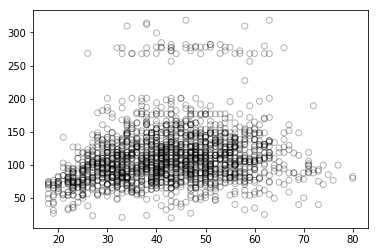

In [19]:
#了解数据
data_x = data['age']
data_y = data['wage']

#将数据划分为训练集和验证集
from sklearn.model_selection import train_test_split
train_x, valid_x, train_y, valid_y = train_test_split(data_x, data_y, test_size=0.33, random_state=1)

#对年龄和工资的关系进行可视化
import matplotlib.pyplot as plt
plt.scatter(train_x, train_y, facecolor='None', edgecolor='k', alpha=0.3)
plt.show()

In [7]:
#======拟合线性回归模型======
from sklearn.linear_model import LinearRegression

x = train_x.reshape(-1, 1)
model = LinearRegression()
model.fit(x, train_y)
print(model.coef_)
print(model.intercept_)

[0.72190831]
80.65287740759285


/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  This is separate from the ipykernel package so we can avoid doing imports until


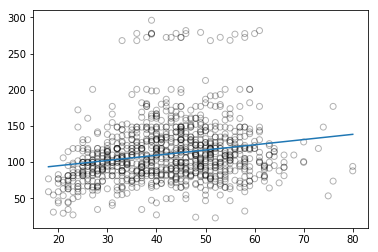

In [14]:
#在验证集上进行预测
valid_x = valid_x.reshape(-1, 1)
pred = model.predict(valid_x)
#可视化
#我们将使用valid_x的最小值和最大值之间的70个点进行绘制
xp = np.linspace(valid_x.min(), valid_x.max(), 70)
xp = xp.reshape(-1, 1)
pred_plot = model.predict(xp)
plt.scatter(valid_x, valid_y, facecolor='None', edgecolor='k', alpha=0.3)
plt.plot(xp, pred_plot)
plt.show()

In [15]:
#对预测出的结果算一下RMSE
from sklearn.metrics import mean_squared_error
from math import sqrt
rms = sqrt(mean_squared_error(valid_y, pred))
print(rms)

40.436687488017256


In [33]:
#======线性回归的改进：多项式回归: x, x↑2, x↑3, ...======

#为回归函数生成权重，设degree=2
weights = np.polyfit(train_x, train_y, 2) #degree=2
print(weights)

[ -0.05194765   5.22868974 -10.03406116]


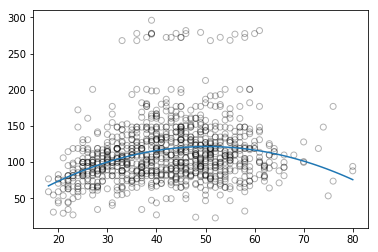

In [34]:
#根据给定的权重生成模型
model = np.poly1d(weights)
#在验证集上进行预测
pred = model(valid_x)

#我们只画出其中的70个点
xp = np.linspace(valid_x.min(), valid_x.max(), 70)
pred_plot = model(xp)
plt.scatter(valid_x, valid_y, facecolor='None', edgecolor='k', alpha=0.3)
plt.plot(xp, pred_plot)
plt.show()

In [35]:
#======样条回归法及其实现======
#将数据划到四个区间中
df_cut, bins = pd.cut(train_x, 4, retbins=True, right=True)
df_cut.value_counts(sort=False)

(17.938, 33.5]    504
(33.5, 49.0]      941
(49.0, 64.5]      511
(64.5, 80.0]       54
Name: age, dtype: int64

In [36]:
df_steps = pd.concat([train_x, df_cut, train_y], keys=['age', 'age_cuts', 'wage'], axis=1)
#将讲年龄编码为哑变量
df_steps_dummies = pd.get_dummies(df_cut)
df_steps_dummies.head()

,"(17.938, 33.5]","(33.5, 49.0]","(49.0, 64.5]","(64.5, 80.0]"
1382,0,1,0,0
23,0,1,0,0
2140,0,0,1,0
1117,1,0,0,0
933,0,1,0,0


In [38]:
df_steps_dummies.columns = ['17.938-33.5', '33.5-49', '49=64.5', '64.5-80']
#拟合广义线性模型
fit3 = sm.GLM(df_steps.wage, df_steps_dummies).fit()
#同样将验证集划分到四个桶中
bin_mapping = np.digitize(valid_x, bins)
X_valid = pd.get_dummies(bin_mapping)
#去掉离群点
X_valid = pd.get_dummies(bin_mapping).drop([5], axis=1)

#进行预测
pred2 = fit3.predict(X_valid)
#计算RMSE
from sklearn.metrics import mean_squared_error
from math import sqrt
rms = sqrt(mean_squared_error(valid_y, pred2))
print(rms)

39.990600783110395


In [41]:
#在这我们只画出70个观察点的图
xp = np.linspace(valid_x.min(), valid_x.max()-1, 70)
bin_mapping = np.digitize(xp, bins)
X_valid_2 = pd.get_dummies(bin_mapping)
pred2 = fit3.predict(X_valid_2)

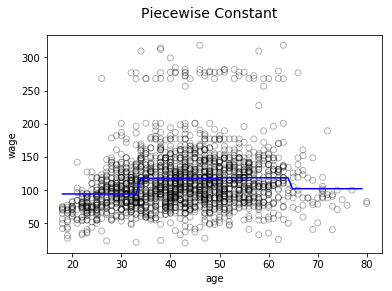

In [46]:
#进行可视化
fig, (ax1) = plt.subplots(1,1)
fig.suptitle('Piecewise Constant', fontsize=14)
#画出样条回归的散点图
ax1.scatter(train_x, train_y, facecolor='None', edgecolor='k', alpha=0.3)
ax1.plot(xp, pred2, c='b')
ax1.set_xlabel('age')
ax1.set_ylabel('wage')
plt.show()

In [50]:
#基函数: yi = B0 + B1f1(x1) + B2f2(x2) + B3f3(x3) + ... + Bkfk(xk)
#一个普遍使用的基函数：分段多项式: yi = B0 + B1xi + B2Xi2
#...
#像这样具有m-1阶连续导数的m阶多项式被称为样条。三次样条是具有一组额外约束（连续性、一阶导数连续性、二阶导数连续性）的分段多项式。通常，一个有K个节点的三次样条其自由度是4+K。
from patsy import dmatrix
import statsmodels.api as sm
import statsmodels.formula.api as smf
#生成一个三节点的三次样条（25,40,60）
transformed_x = dmatrix("bs(train, knots=(25,40,60), degree=3, include_intercept=False)", {"train": train_x}, return_type='dataframe')

#在数据集及上拟合广义线性模型
fit1 = sm.GLM(train_y, transformed_x).fit()

#生成一个4节点的三次样条曲线
transformed_x2 = dmatrix("bs(train, knots=(25,40,50,65), degree=3, include_intercept=False)", {"train": train_x}, return_type='dataframe')

#在数据集上拟合广义线性模型
fit2 = sm.GLM(train_y, transformed_x2).fit()

#在两个样条上均进行预测
pred1 = fit1.predict(dmatrix("bs(valid, knots=(25,40,60), include_intercept=False)", {"valid": valid_x}, return_type='dataframe'))
pred2 = fit2.predict(dmatrix("bs(valid, knots=(25,40,50,65), degree=3, include_intercept=False)", {"valid": valid_x}, return_type='dataframe'))

#计算RMSE值
valuesrms1 = sqrt(mean_squared_error(valid_y, pred1))
print(valuesrms1)
rms2 = sqrt(mean_squared_error(valid_y, pred2))
print(rms2)

39.40318768341124
39.34292609147628


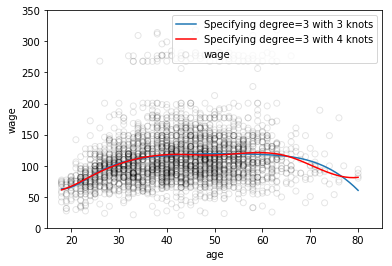

In [51]:
#我们将使用70个点进行图形的绘制
xp = np.linspace(valid_x.min(), valid_x.max(), 70)
#进行一些预测
pred1 = fit1.predict(dmatrix("bs(xp, knots=(25,40,60), include_intercept=False)", {"xp": xp}, return_type='dataframe'))
pred2 = fit2.predict(dmatrix("bs(xp, knots=(25,40,50,65), degree=3, include_intercept=False)", {"xp": xp}, return_type='dataframe'))

#画出样条曲线和误差图
plt.scatter(data.age, data.wage, facecolor='None', edgecolor='k', alpha=0.1)
plt.plot(xp, pred1, label='Specifying degree=3 with 3 knots')
plt.plot(xp, pred2, color='r', label='Specifying degree=3 with 4 knots')
plt.legend()
plt.xlim(15, 85)
plt.ylim(0, 350)
plt.xlabel('age')
plt.ylabel('wage')
plt.show()

In [53]:
#生成自然三次样条
transformed_x3 = dmatrix("cr(train, df=3)", {"train": train_x}, return_type='dataframe')
fit3 = sm.GLM(train_y, transformed_x3).fit()

#在验证集上进行预测
pred3 = fit3.predict(dmatrix("cr(valid, df=3)", {"valid": valid_x}, return_type='dataframe'))
#计算RMSE的值
rms = sqrt(mean_squared_error(valid_y, pred3))
print(rms)

39.44823813743623


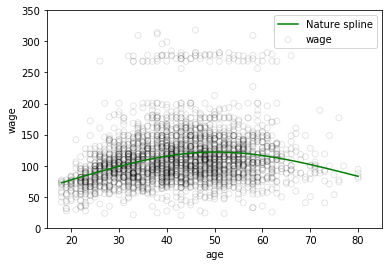

In [54]:
#选取其中70个点进行作图
xp = np.linspace(valid_x.min(), valid_x.max(), 70)
pred3 = fit3.predict(dmatrix("cr(xp, df=3)", {"xp": xp}, return_type='dataframe'))
#画出样条曲线
plt.scatter(data.age, data.wage, facecolor='None', edgecolor='k', alpha=0.1)
plt.plot(xp, pred3, color='g', label='Nature spline')
plt.legend()
plt.xlim(15, 85)
plt.ylim(0, 350)
plt.xlabel('age')
plt.ylabel('wage')
plt.show()